# mujoco 基础知识学习
根据 mujoco 官方提供的tutorial 来学习
官方的连接如下[mujoco tutorial](https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/tutorial.ipynb#scrollTo=MpkYHwCqk7W-)


In [1]:
# 基础的一些库导入
import mujoco
import time
import itertools
import numpy as np
import matplotlib.pyplot as plt
import mediapy as media
from IPython.display import display

## 从定义和加载一个简单的模型开始

In [2]:
xml = """
<mujoco>
  <worldbody>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)

这份xml是 MuJoCo 的 MJCF 格式，是一种基于XML 的模型语言
+ 唯一需要的element is ```<mujoco>```,最小的合法MJCF 模型就是```<mujoco/>```， 是一个空的模型
+ 所有的物理元素都包含在```<worldbody>```这个里面。它是最顶层的body
+ 这个```from_xml_string()``` 方法调用了模型的编译器，然后创建了一个```mjModel``` 实例

## mjModel
```mjModel``` 包含了模型的描述，是不会随着时间改变的一些量。
例如```ngeom``` 是场景中的几何体的数量， ```geom_rgba``` 是每个几何体的颜色

In [3]:
print(model.ngeom)
model.geom_rgba

2


array([[1., 0., 0., 1.],
       [0., 1., 0., 1.]], dtype=float32)

MuJoCo 提供便捷的通过使用名字的accessors，调用 model.geom()，但是如果不传入name string 那么就会抛出异常，提示你合法的名字是什么

In [4]:
try:
    model.geom()
except KeyError as e:
    print(e)

"Invalid name ''. Valid names: ['green_sphere', 'red_box']"


In [5]:
model.geom('green_sphere')
model.geom('red_box').rgba

array([1., 0., 0., 1.], dtype=float32)

In [6]:
# 通过mj_name2id 这个function 可以把名字转成对应的id
id =  mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_GEOM, 'green_sphere')
model.geom_rgba[id, :]

array([0., 1., 0., 1.], dtype=float32)

In [7]:
# model.ngeom 可以获取这个model里面有多少个geom
[model.geom(i).name for i in range(model.ngeom)]

['red_box', 'green_sphere']

## mjData
它包含了关于geom的state 以及相关的一些量，state 是有 time、generalized positions and generalized velocities

In [8]:
data = mujoco.MjData(model)
print(data.geom_xpos)

[[0. 0. 0.]
 [0. 0. 0.]]


可以看到，我们的两个geom 的位置都是在origin，但是我们在xml中是移动了green_sphere的位置的，为什么输出的值没有改变呢？
因为 ```mjData``` 里面这些是derived quantities,需要被 explicitly propagated,才能更新。

In [9]:
mujoco.mj_kinematics(model,data)
print('raw accesss:\n', data.geom_xpos)

raw accesss:
 [[0.  0.  0. ]
 [0.2 0.2 0.2]]


## 基本的渲染、模拟和animation
为了渲染，我们需要一个```Renderer```的实例，然后调用它的```render```方法

""

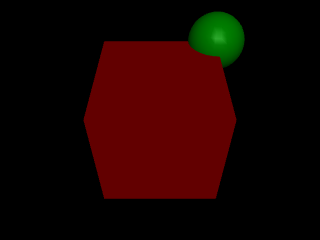

In [10]:
xml = """
<mujoco>
  <worldbody>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
# Make model and data
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# Make renderer, render and show the pixels
with mujoco.Renderer(model) as renderer:
    mujoco.mj_forward(model, data)
    renderer.update_scene(data)

    media.show_image(renderer.render())

""

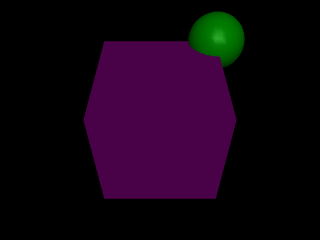

In [11]:
model.geom('red_box').rgba[:3] = np.random.rand(3)
with mujoco.Renderer(model) as renderer:
    #为什么这里只需要update scene，而不需要 mj_forward呢，因为更新的是颜色，不是state 变量
  renderer.update_scene(data)

  media.show_image(renderer.render())

## start simulation
之前只是展示了图片，现在开始仿真，输出一个video，仿真需要用到的方法是：```mj_step```，用于迭代$x_{t+h} = f(x)$
注意，我们不需要每次render之后都调用```mj_step```，因为默认的时间间隙是2ms，我们只需要60fps的video

In [12]:
duration = 3.8
framerate = 60
frames = []
mujoco.mj_resetData(model,data)
with mujoco.Renderer(model) as renderer:
    while data.time< duration:
        mujoco.mj_step(model, data)
        if len(frames) < data.time * framerate:
            renderer.update_scene(data)
            pixels = renderer.render()
            frames.append(pixels)

media.show_video(frames, fps = framerate)

可以看到，生成的这个视频，物体都是静止的，这是因为，这个model 没有 degrees of freedom,可以动的物体被称作 *bodies*，我们在*bodies* 里面添加*joints* 可以增加自由度。

In [13]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

model.opt.gravity = (0,0,10)

duration = 3.8  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)
with mujoco.Renderer(model) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data, scene_option=scene_option)
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)